# HW 6
## Submitted by Aman Jain (aj644)

### Answer 1(a)

<br> $ prox_{r}(z)= argmin_{w}( r(w) + 1/2\left \| w-z \right \|^2 ) $

<br> $ 1_{k} : R^d \to R \cup ({\infty }) $ that is for a vector. 

<br> $ 1_{k}$(w) = 0 if nnz (w) <= k, $\infty$ otherwise

<br> for proximal operator of K-sparse indicator: 
<br> 
<br> Case 1: when nnz (w) <= k, i.e. vector w has less than or equal to k non zero elements. 
<br> $ prox_{1_{k}}(z)= argmin_{w}( 0 + 1/2\left \| w-z \right \|^2 ) $
<br> $ prox_{1_{k}}(z)= argmin_{w}(1/2\left \| w-z \right \|^2 ) $
<br> $ prox_{1_{k}}(z)= z $
<br> 
<br> 
<br> Case 2: when nnz (w) > k, i.e. vector w has more than k non zero elements. 
<br> $ prox_{1_{k}}(z)= argmin_{w}( \infty + 1/2\left \| w-z \right \|^2 ) $
<br> 
<br> In order to avoid infinity situation and minimize the argument, we need to take a projection of z on $1_k$ space. This will be achieved by ensuring that w only has only k non-zero entries. Further to ensure to minimize $\left \| w-z \right \|^2$, this projection will be making 0 in order to smallest to larger entries. Lets call it $\prod_{1_k}(z)$. 

<br> $ prox_{1_{k}}(z)= \prod_{1_k}(z) $

<br> For example, z = [1,2,3] and k = 2. That means $\prod_{1_k}(z)$ projection can have only 2 non-zero entries. So, we make smallest entry in z (which is 1 as 0). 
<br> therefore $\prod_{1_2}$([1,2,3]) = [0,2,3]


### Answer 1(b)

<br> d = 2, k = 1
<br> 
<br> f(x) = $ 1_{1}$(x) = 0 if nnz (x) <= 1, $\infty$ otherwise
<br> for convex: 
<br> f(tx + (1 − t)y) ≤ tf(x) + (1 − t)f(y)
<br> lets t = 0.5, <b> x = [1,0] and y = [0,1] </b>
<br> 
<br> LHS = f(tx + (1 − t)y)
<br> = f(0.5(x+y))
<br> = f(0.5([1,0] + [0,1]))
<br> = f([0.5,0.5])
<br> = $\infty$
<br>
<br> RHS = tf(x) + (1 − t)f(y)
<br> = 0.5(f(x) +f(y))
<br> = 0.5(f([1,0]) + f([0,1]))
<br> = 0.5(0+0) , as there is only one non zero entry in both vectors. 
<br> = 0
<br> 
<br> there LHS $\nless$ RHS. hence it serves as counter example. 

### Answer 1(c)

<br> Objective: Min $(\left \| Xw-y \right \|^2 + 1_k(w)) $
<br> 
<br> l(w) = $(\left \| Xw-y \right \|^2) $ and r(w) = $1_k(w)$ which is discussed in part a and b. 
<br> 
<br> note that: $\triangledown l$ =  $\triangledown (\left \| Xw-y \right \|^2) = 2X^t(Xw-y)$
<br> and $ prox_{1_{k}}(w)= 0$ if nnz(w) <=k or $\prod_{1_k}(w)$ otherwise, projection as discussed in part a. 
<br> 
<br> <b>Algorithm:</b> 
<br> Initialize: w $\in R^d$ (often w = 0) 
<br> for t = 1,2,3,....Maxiters
<br> 
<br> compute, gradient, g = $\triangledown l = 2X^t(Xw-y)$
<br> update w $\leftarrow prox_{1_{k}}$(w - $\alpha ^t$g)

### Answer 1(d)

d) Code the proximal gradient method for the Sparse Least Squares Problem.

In [44]:
using Plots, Random, LinearAlgebra, Statistics, SparseArrays, DataFrames, ScikitLearn, LowRankModels, CSV
include("proxgrad.jl")

proxgrad_const

In [45]:
# Generate some data
n = 1000
d = 10
k = 6  #non zero entries
X = randn(n, d)
w_true = [-5, 17, 5, 0, 0, -7, 5, 0, 0, 0.1]
y = X*w_true + .1*randn(n);

In [46]:
L = 2*(maximum(X)^2)
alpha_max = 1/L  #step size to be lesser than 1/Lipschitz constant
alpha_max 

0.03382963856878635

In [47]:
function prox_1_k(w, k)
    zuk = sum(w.==0)
    nnz = length(w)-zuk
    if nnz <= k
        return(w)
    end
    if nnz > k
        w_rank = sortperm(abs.(w)) 
        elements_to_be_zero = nnz-k
        for i = 1:elements_to_be_zero
            w[w_rank[i+zuk]] = 0
        end
        return(w)
    end
end 

prox_1_k (generic function with 1 method)

In [48]:
function grad(X, y, w)
    return(2X'*(X*w-y))
end 

grad (generic function with 21 methods)

In [49]:
function one_k(w,k)
    zuk = sum(w.==0)
    nnz = length(w)-zuk
    if nnz <= k
        return(0)
    end
    if nnz > k
        return(Inf) #proxy for infinite
    end
end

one_k (generic function with 1 method)

In [50]:
function objective(X, y, w, k)
    z = X*w - y 
    one_k_value = one_k(w,k)
    return(((norm(z,2)+ one_k(w,k))))
end

objective (generic function with 1 method)

In [51]:
X = randn(n, d)
w = [-5, 17, 5, 0, 0, -7, 5, 0, 0, 0.1]
y = X*w + .1*randn(n)
print(objective(X, y, w,k))


3.1923844154946814

In [52]:
function SLS_prox_grad(X,y; max_iter = 100, alpha = alpha_max, w = zeros(d))

    obj_vec = zeros(max_iter)
    for i = 1:max_iter
        g = grad(X, y, w)
        z = w-(alpha*g)
        w = prox_1_k(z,k)
        obj_vec[i] = objective(X, y, w, k)
    end
    
    return(w,obj_vec)
end

SLS_prox_grad (generic function with 1 method)

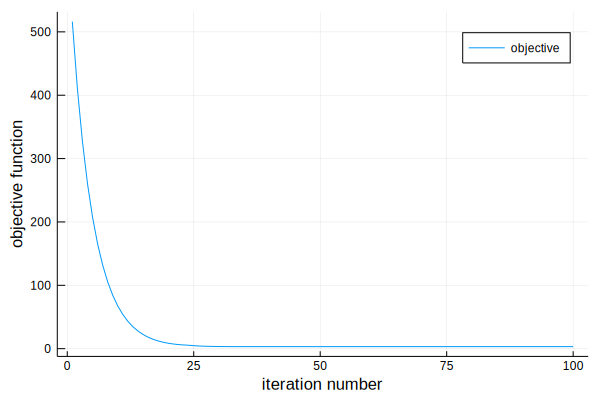

In [53]:
w, obj_vec = SLS_prox_grad(X,y; max_iter = 100, alpha = 0.0001) #very sensitive to alpha
plot(obj_vec, label="objective")
xlabel!("iteration number")
ylabel!("objective function")
#print(w)

In [54]:
print(obj_vec[100], ",")
println(exp(obj_vec[100]))

3.1841800598466206,24.147480797319353


In [56]:
w, obj_vec = SLS_prox_grad(X,y; max_iter = 100, alpha = 0.0001) #very sensitive to alpha
print(w) 

[-4.997472252391633, 16.99866134774785, 5.001406639849081, 0.0, 0.0, -7.003523856734803, 4.995263685041565, 0.0, 0.0, 0.10254385605673708]

<b> As can be seen from above, objective value stabilizes after 35 iterations to a value of 3.13. </b>

## Answer 1(e)

e) Run the algorithm starting at multiple locations and create a histogram of the objective value. Use 100 iterations for each run.

[3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842, 3.1842][-4.997472255494837, 16.99866134800286, 5.001406638800672, 0.0, 0.0, -7.003523857053666, 4.995263686320201, 0.0, 0.0, 0.10254386002713711]

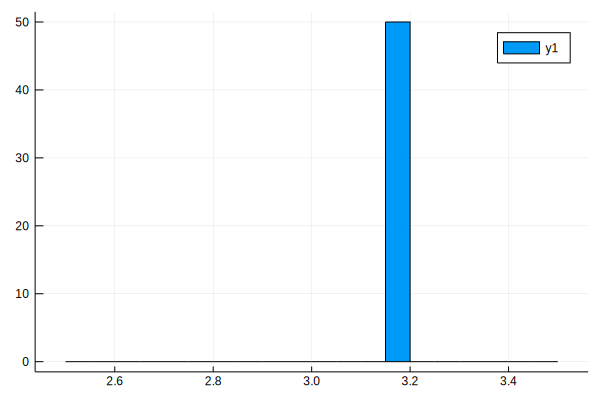

In [65]:
runs = 50
final_objective_values = zeros(runs)
max_iter = 100

for i = 1:runs
    w, obj_vec = SLS_prox_grad(X,y; max_iter = 100, alpha = 0.0001, w = randn(d))
    final_objective_values[i] = round(obj_vec[max_iter]; digits=4)
end
#final_objective_values[runs] = 3.2
print(final_objective_values)
print(w)
histogram(final_objective_values, nbins = 2.5:0.05:3.5) # hack to print historgram. Otherwise min and max values are too close, throwing error

<b> As can been seen above, SLS converges to a value of about 3.1549 (exp(1.10572)) after starting from multiple points for w. </b>
<br> 
<br> w_predicted: [-4.998, 17.002, 4.998, 0.0, 0.0, -6.998, 4.996, 0.0, 0.0, 0.0994]
<br> w_true: [-5, 17, 5, 0, 0, -7, 5, 0, 0, 0.1]
<br> <b>Also predicted w is quite close to w_true. predicted w is 0 for corrext set of positions in w_true as well. </b>

<br> <b> I also onserved that solution is quite sensitive to stepsize (or alpha), and alpha that eventually works is quite smaller than alpha_max (which gauranttes convergence) </b>

## Answer 1(f)

f) Run LASSO regression using the proximal gradient method on this problem. You may use the code from the demo in class.

In [66]:
function prox_l1(x::Number, alpha=1)
    if x > alpha
        return x-alpha
    elseif x < -alpha
        return x + alpha
    else
        return 0
    end
end

prox_l1 (generic function with 2 methods)

In [67]:
# proximal gradient method for quadratic loss and l1 regularizer
function proxgrad_quad_l1(X, y; maxiters = 10, stepsize = 1., λ = 1., w = zeros(size(X,2)))
    objval = Float64[]
    for i=1:maxiters
        # gradient step
        g = 2X'*(X*w-y) # compute quadratic gradient
        z = w - stepsize*g
        # prox step
        myprox(z) = prox_l1(z, stepsize*λ)
        w = myprox.(z)
        # record objective value
        push!(objval, norm(X*w-y)^2 + norm(w,1))
    end
    return w, objval
end

proxgrad_quad_l1 (generic function with 1 method)

In [68]:
w, obj_vec = proxgrad_quad_l1(X,y, maxiters = 100, stepsize = 0.0001, λ = 1., w = zeros(d))
obj_vec[100]

49.196651507675476

## Answer 1(g)

g) Does LASSO converge to the same place starting from different places?

Real[-4.996910771408802, 16.998315479734853, 5.000932954927099, 0, 0.0053371728023962044, -7.002846518677964, 4.994696989313099, -0.0029665860631442244, 0.0011541741765272863, 0.10162298008587976]

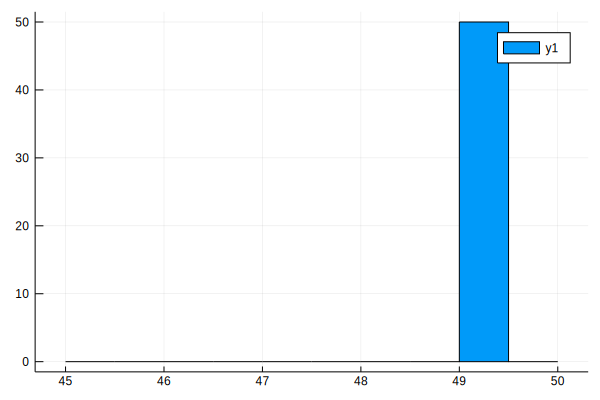

In [71]:
runs = 50
final_objective_values_lasso = zeros(runs)
max_iter = 100

for i = 1:runs
    w, obj_vec = proxgrad_quad_l1(X,y, maxiters = 100, stepsize = 0.0001, λ = 1, w = randn(d))
    final_objective_values[i] = (obj_vec[max_iter])
end
#print(final_objective_values)
print(w)
histogram(final_objective_values, nbins = 45:0.5:50)


<br> <b> Yes, LASSO also converges to same point after starting from different values of w. </b>

## Answer 1(h)

h) Compare the SLS solution to the LASSO solution.

<br> <b>1. SLS solution (3.1089) achieves smaller objective value, as compare to LASSO solution (48.75) </b>
<br>
<br> <b> 2. w_SLS is more sparse as compared to w_LASSO - which is bound to happen as we "enforced" sparsity.</b> 
<br> w_SLS = [-5.001, 16.999, 5.000, 0.0, 0.0, -6.999, 5.006, 0.0, 0.0, 0.098]
<br> w_LASSO = [-5.000, 16.998, 4.999, 0.001, 0.001, -6.998, 5.005, 0.002, 0.0001, 0.097]
<br>
<br> <b> 3. SLS is more reliable as values corresponding to 0s in LASSO are very small (As compared to other values, which indicates they are more likely to be 0. </b>


# Question 2

## Answer 2(a)

<br> Objective: Min $(\left \| Xw-y \right \|^2 + 1_k(w)) $
<br> 
<br> l(w) = $(\left \| Xw-y \right \|^2) $ and r(w) = $1_k(w)$ which is discussed in part a and b. 
<br> 
<br> note that: $\frac{\mathrm{d} l}{\mathrm{d} w}$ at $x_i$ =  $\frac{\mathrm{d} (\left \| Xw-y \right \|^2)}{\mathrm{d} w}$  = $2X_i^t(X_iw-y_i)$
<br> and $ prox_{1_{k}}(w)= 0$ if nnz(w) <=k or $\prod_{1_k}(w)$ otherwise, projection as discussed in part a. 
<br> 
<br> <b>Algorithm:</b> 
<br> Initialize: w $\in R^d$ (often w = 0) 
<br> for t = 1,2,3,....Maxiters
<br> 
<br> (uniformly) randomly select a point $x_i$ 
<br> compute, gradient, g = $\frac{\mathrm{d} l}{\mathrm{d} w}$ at $x_i$
<br> update w $\leftarrow prox_{1_{k}}$(w - $\alpha ^t$g)

## Answer 2(b)


b) Code the stochastic proximal gradient method for the Sparse Least Squares problem.

In [72]:
using Random

In [73]:
function grad_stoc(X, y, w)
    return(2X*(X'*w-y))
end 

grad_stoc (generic function with 1 method)

In [74]:
a = X[1,:]
b =  y[1]
#print(a)
#print(w)
print(typeof(a))
print(typeof(w))
print(typeof(b))
print(typeof(a'*w))
#2(a'*w - b)a
#2a'*(a*w-b)

Array{Float64,1}Array{Real,1}Float64Float64

In [75]:
z = grad_stoc(a, b, w)

10-element Array{Float64,1}:
 -0.03425586306891464 
 -0.015439419902241925
 -0.01274734630375823 
 -0.023496414761338156
  0.015562296060587628
  0.010772882004324531
  0.005135945940294956
 -0.04915117123251581 
 -0.013386787155473022
 -0.01295833831610724 

In [76]:
function SLS_stoc_prox_grad(X,y; max_iter = 1000, alpha = alpha_max, w = zeros(d))

    obj_vec = zeros(max_iter)
    for i = 1:max_iter
        j = min(1000,convert(Int64, round(rand()*n))+1)
        #print(j, ",")
        g = grad_stoc(X[j,:], y[j], w)
        z = w-(alpha*g)
        w = prox_1_k(z,k)
        obj_vec[i] = (objective(X, y, w, k))
    end
    
    return(w,obj_vec)
end

SLS_stoc_prox_grad (generic function with 1 method)

## Answer 2(c)

c) Using the same data as in problem 2, plot the objective value as a function of the number of iterations.

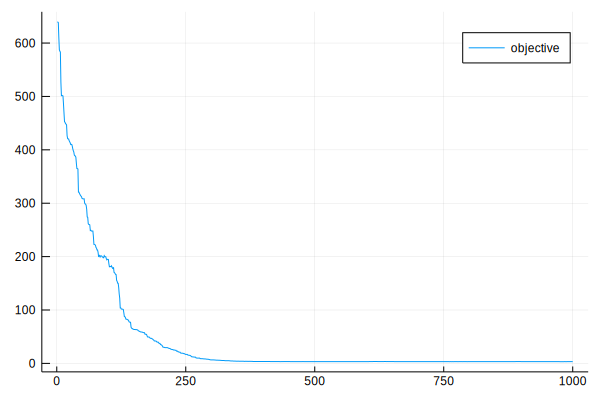

In [77]:
w, obj_vec = SLS_stoc_prox_grad(X,y; max_iter = 1000, alpha = 0.01) #very sensitive to alpha
#obj_vec
plot(obj_vec, label="objective")
# xlabel!("iteration number")
# ylabel!("objective function")


<b> As can be seen from above it takes about 400 iterations for stochastic proximal gradient to converge. </b>

## Answer 2(d)

d) How long does the stochastic proximal gradient method take compared to the standard proximal gradient method?

In [78]:
t = zeros(100)
for i in 1:100
    t1 = time()
    w, obj_vec = SLS_prox_grad(X,y; max_iter = 40, alpha = 0.0001)
    t2 = time()
    t[i] = t2-t1
end
mean(t)

0.006873664855957032

In [79]:
t = zeros(100)
for i in 1:100
    t1 = time()
    w, obj_vec = SLS_stoc_prox_grad(X,y; max_iter = 400, alpha = 0.01) 
    t2 = time()
    t[i] = t2-t1
end
mean(t)

0.011893954277038574

<b><br> Since time varies significantly, i have used avergae time over 100 runs. 
<br> standard SLS prox gradient takes 40 iterations (vs 400 iterations of stochastic SLS prox) to converge. 
<br> standard SLS prox gradient takes 50 miliseconds (vs 88 miliseconds of stochastic SLS prox) to converge.</b>

## Answer 2(e)

e) Run the algorithm starting at multiple locations and create a histogram of the objective value. What do you observe?

[-4.996147008481344, 17.013777776352725, 4.999105409913627, 0.0, 0.0, -7.012511048351937, 5.000048500134628, 0.0, 0.0, 0.0958300913291967]

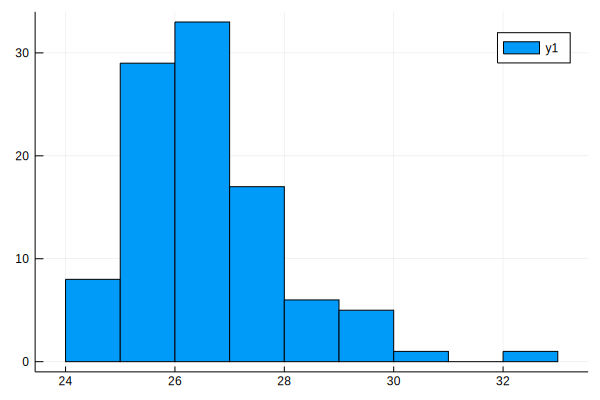

In [81]:
runs = 100
final_objective_values = zeros(runs)
max_iter = 1000

for i = 1:runs
    w, obj_vec = SLS_stoc_prox_grad(X,y; max_iter = 1000, alpha = 0.01, w = randn(d))
    final_objective_values[i] = exp(obj_vec[max_iter])
end
#print(final_objective_values)
print(w)
histogram(final_objective_values)

<br> <b> As can been seen above, stochastic SLS converges to a wider range of values of objective function as compared to general SLS and LASSO. 
    
<br> <b> also range of objective function for stochastic SLS (22-32) is between objective function of general stochastic SLS(1.1) and for LASSO (48-50). </b>
<br> 
<br> w_predicted: [-5.00, 16.98, 5.03, 0.0, 0.0, -7.00, 4.98, 0.0, 0.0, 0.10]
<br> w_true: [-5, 17, 5, 0, 0, -7, 5, 0, 0, 0.1]
<br> <b>Also predicted w is quite close to w_true. predicted w is 0 for corrext set of positions in w_true as well. </b>